In [10]:
%logstop
%logstart -rtq ~/.logs/ML_ModelSelection.py append
%matplotlib inline
import matplotlib
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 144

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.datasets
from ipywidgets import interact

# Model selection
<!-- requirement: images/ml_map.png -->

We have defined machine learning as the process of optimizing the cost function by tweaking the parameters of a model. We have defined a model as some map that uniquely maps input (features) to output (labels or target values). We've left this definition very vague, because there are many popular models used for machine learning. In this notebook we'll explore a few of them and investigate how to choose between different possible models.

In [20]:
!wget http://dataincubator-wqu.s3.amazonaws.com/caldata/cal_housing.pkz -nc -P ~/scikit_learn_data/

File ‘/home/jovyan/scikit_learn_data/cal_housing.pkz’ already there; not retrieving.



In [21]:
from sklearn.datasets import fetch_california_housing

cali_data = fetch_california_housing()

cali_df = pd.DataFrame(cali_data.data, columns=cali_data.feature_names)
cali_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


We'll again work with the California data set, predicting home values based on the features. While this is a regression task, the concepts involved in model selection also apply to classification tasks, and many models are capable of both regression and classification.

## Exploratory analysis

Model selection begins with characterizing our data: how many features are there, how many observations, are any features correlated, are the relationships between features and labels linear or nonlinear, is the variance in the features uniform, etc.? The `scikit-learn` documentation includes a [flowchart](http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) illustrating just some possible models and factors we might consider while we're exploring our data set.

![ml_model_flowchart](images/ml_map.png)

We'll dive deeper into some of these considerations in future lessons. First let's visualize our data.

In [27]:
def plot_feature(feature):
    plt.plot(cali_df[feature], cali_data.target, '.')
    plt.xlabel(feature)
    plt.ylabel('Median home value')

menu = cali_data.feature_names

interact(plot_feature, feature=menu);

interactive(children=(Dropdown(description='feature', options=('MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', …

The relationship between home value and some of the features looks very linear (e.g. median income), but others look non-linear or random (e.g. house age or geography). We've discussed [linear regression](ML_LinearRegression.ipynb) -- let's try modeling one of the non-linear features.

## Decision Trees

A decision tree is essentially a logic tree that branches based on feature values.

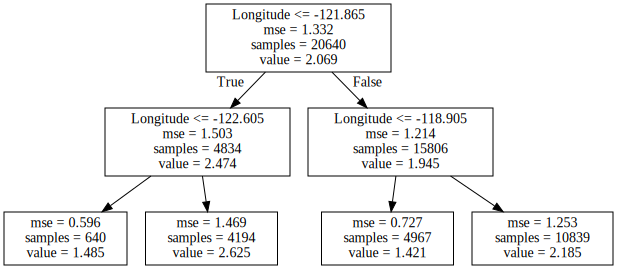

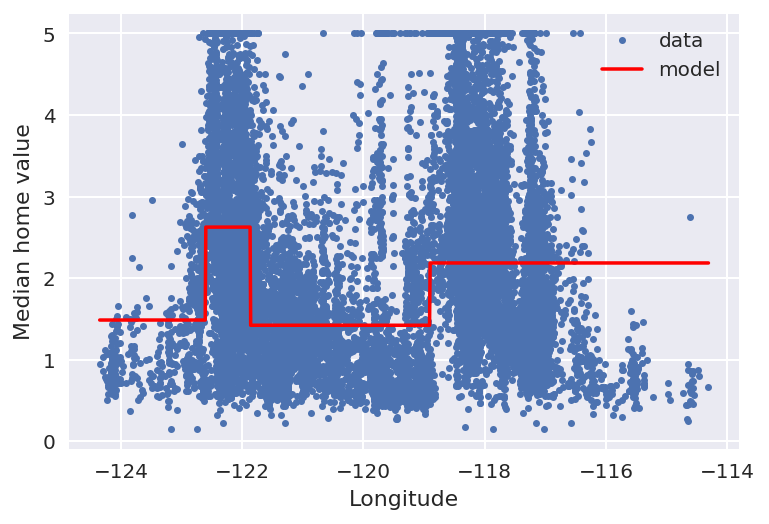

In [38]:
from sklearn import tree
from IPython import display
from graphviz import Source

model = tree.DecisionTreeRegressor(max_depth=2)
model.fit(cali_df['Longitude'].to_frame(), cali_data.target)

plt.plot(cali_df['Longitude'], cali_data.target, '.', label='data')
plt.plot(cali_df['Longitude'].sort_values(), 
         model.predict(cali_df['Longitude'].sort_values().to_frame()), 
         'r-', label='model')

plt.xlabel('Longitude')
plt.ylabel('Median home value')
plt.legend()

graph = Source(tree.export_graphviz(model, out_file=None, feature_names=['Longitude']))
display.SVG(graph.pipe(format='svg'))

## By allowing for more branching, we can make our model more complex. Does this make our model better or worse?

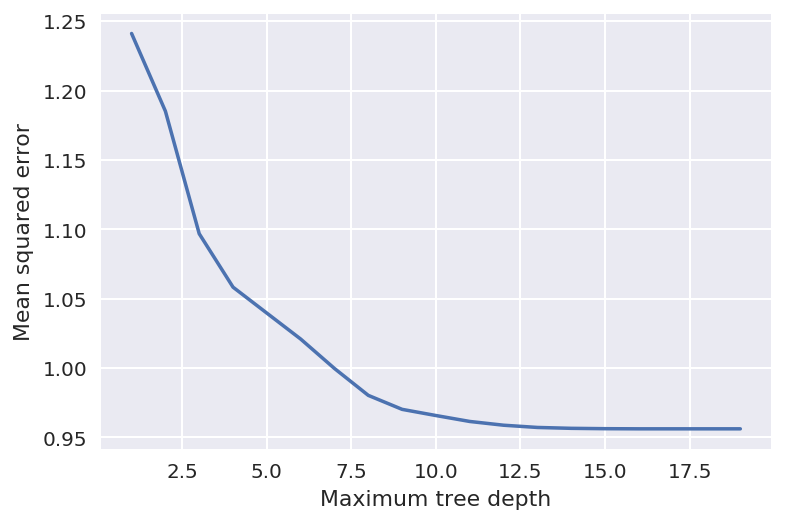

In [44]:
from sklearn.metrics import mean_squared_error as mse

max_depths = range(1, 20)
training_error = []
for max_depth in max_depths:
    model = tree.DecisionTreeRegressor(max_depth=max_depth)
    model.fit(cali_df['Latitude'].to_frame(), cali_data.target)
    training_error.append(mse(cali_data.target, model.predict(cali_df['Latitude'].to_frame())))

plt.plot(max_depths, training_error)
plt.xlabel('Maximum tree depth')
plt.ylabel('Mean squared error');

We reach a conflict: the model looks qualitatively worse beyond `max_depth > 5` but the error keeps dropping. This problem is called _overfitting_. The model looks worse because it doesn't follow the trend of the data, but instead follows the random noise. To detect overfitting, we need to see how our model generalizes to new data. We can do this artificially by withholding part of our data set during the training step, and then using it to test the model.

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

X_train, X_test, y_train, y_test = train_test_split(*shuffle(cali_df['Longitude'].to_frame(), 
                                                             cali_data.target), test_size=0.1)

print(X_train.shape)
print(X_test.shape)

(18576, 1)
(2064, 1)


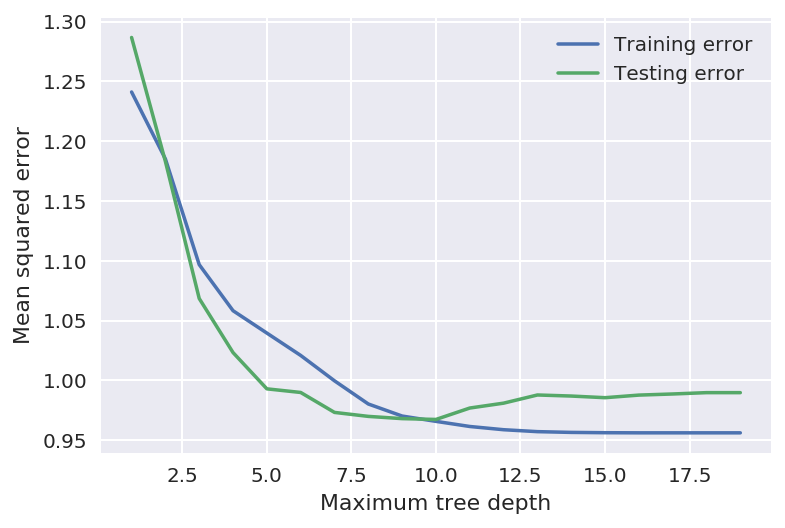

In [46]:
testing_error = []
for max_depth in max_depths:
    model = tree.DecisionTreeRegressor(max_depth=max_depth)
    model.fit(X_train, y_train)
    testing_error.append(mse(y_test, model.predict(X_test)))

plt.plot(max_depths, training_error, label='Training error')
plt.plot(max_depths, testing_error, label='Testing error')
plt.xlabel('Maximum tree depth')
plt.ylabel('Mean squared error')
plt.legend();

The testing error confirms our suspicion. As the model becomes more complex, it improves up to a point, and then it loses generalizability. One way to track complexity is the number of _parameters_ in our model. If we labeled each layer of our tree (starting with 0), we see there are $2^i$ parameters on layer $i$. Therefore the total number of parameters is $\sum_i 2**i$

In [48]:
list(zip(max_depths, [sum([2**i for i in range(max_depth)]) for max_depth in max_depths]))

[(1, 1),
 (2, 3),
 (3, 7),
 (4, 15),
 (5, 31),
 (6, 63),
 (7, 127),
 (8, 255),
 (9, 511),
 (10, 1023),
 (11, 2047),
 (12, 4095),
 (13, 8191),
 (14, 16383),
 (15, 32767),
 (16, 65535),
 (17, 131071),
 (18, 262143),
 (19, 524287)]

If we have enough parameters, we can simply memorize our training set, by creating a complex logical tree that separates all the different $X$ values in our training into unique branches of our tree. But _memorization is not learning_.

## Hyperparameters: tuning and cross-validation

When we defined our decision tree estimator, we chose how many layers the tree would have using the `max_depth` keyword. When we initiate an estimator, we can pass keyword arguments that will dictate its structure. The decision tree regressor accepts [12 different keyword arguments](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor). These arguments are called _hyperparameters_. This is in contrast to _parameters_, which are the numbers that our model uses to predict labels based on features. _Parameters_ are optimized during training. _Hyperparameters_ are decided before training and dictate the model's structure. Basically all models have hyperparameters. Even a simple linear regressor has a hyperparameter `fit_intercept`.

Since changing hyperparameters changes the structure of the model, we should think of choosing hyperparameters as part of model selection. `Scikit-learn` provides a useful tool for comparing different hyperparameter values, `GridSearchCV`. There are two ideas behind `GridSearchCV`: first we will split up the data into a training and validation set (using a method called [k-folds](http://scikit-learn.org/stable/modules/cross_validation.html#k-fold)) and then we train and evaluate models with different hyperparameters selected from a grid of combinations.

In [53]:
from sklearn.model_selection import GridSearchCV

model = tree.DecisionTreeRegressor()

gs = GridSearchCV(model,
                  {'max_depth': range(1, 15),
                  'min_samples_split': range(10, 110, 10)},
                  cv=5,
                  n_jobs=2,
                  scoring='neg_mean_squared_error')

gs.fit(X_train, y_train)

print(gs.best_params_)

{'max_depth': 9, 'min_samples_split': 100}


0.9676953032288694


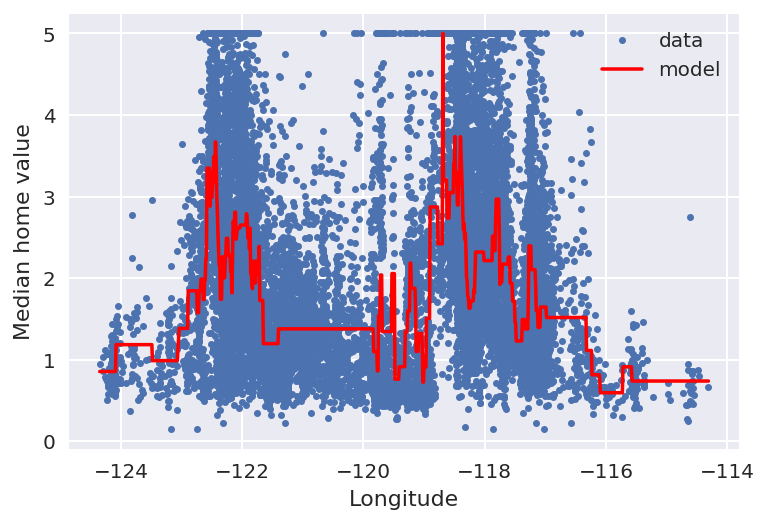

In [55]:
model = gs.best_estimator_
model.fit(X_train, y_train)

plt.plot(cali_df['Longitude'], cali_data.target, '.', label='data')
plt.plot(cali_df['Longitude'].sort_values(), model.predict(cali_df['Longitude'].sort_values().to_frame()), 'r-', label='model')
plt.xlabel('Longitude')
plt.ylabel('Median home value')
plt.legend()

print(mse(y_test, model.predict(X_test)))

## Comparing different estimators

`Scikit-learn`'s `GridSearchCV` only takes one estimator, so while it is useful for hyperparameter tuning, we can't use it to compare different estimators. However, we could easily iterate over different estimators, tune their hyperparameters using `GridSearchCV`, and use a metric to compare their performance.

For example, K-Neighbors is a very flexible model that uses the k-nearest points in feature space to predict the value of a new observation. Will this perform better than our decision tree?

In [57]:
from sklearn.neighbors import KNeighborsRegressor

tree_reg = tree.DecisionTreeRegressor()
knn_reg = KNeighborsRegressor()

estimators = {'tree_reg': tree_reg, 'knn_reg': knn_reg}
hyperparam_dict = {'tree_reg': {'min_samples_split': range(10, 110, 10), 'max_depth': range(1, 15)}, 'knn_reg': {'n_neighbors': range(10, 100, 10)}}

scores = {}
for name, estimator in estimators.items():
    gs = GridSearchCV(estimator,
                      hyperparam_dict[name],
                      cv=5,
                      n_jobs=2,
                      scoring='neg_mean_squared_error')
    
    gs.fit(X_train, y_train)

    scores[name] = -gs.best_score_

print(scores)

{'tree_reg': 0.930233553974231, 'knn_reg': 0.9204411911978867}


### Question:
- K-Neighbors performed better than our decision tree; why might we pick decision tree even though it performs worse?

*Copyright &copy; 2020 The Data Incubator.  All rights reserved.*